# Introduction

In this notebook we will preprocess and convert data from 3D volumes to 2D slices for deep learning. To generate label masks, 3D slicer is used with NVidia AI Assisted Annotation tool to speed up the process.

# Import modules

In [1]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

C:\Users\rajah\anaconda3\envs\seg_env\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


# Define paths and constants

In [2]:
# Paths for input volumes

DATA_ROOT = 'E:/skia_projects/ct_segmentation_3d/data_nifti'
TRAIN_ROOT = os.path.join(DATA_ROOT, 'train')
VALID_ROOT = os.path.join(DATA_ROOT, 'valid')

trainInDir = os.path.join(TRAIN_ROOT, 'volumes/')
trainInMasks = os.path.join(TRAIN_ROOT, 'masks/')

valInDir = os.path.join(VALID_ROOT, 'volumes/')
valInMasks = os.path.join(VALID_ROOT, 'masks/')

In [3]:
# Paths for output slices
OUT_ROOT = 'E:/skia_projects/ct_segmentation_3d/data_slices'
TRAIN_ROOT = os.path.join(OUT_ROOT, 'train')
VALID_ROOT = os.path.join(OUT_ROOT, 'valid')

trainOutDir = os.path.join(TRAIN_ROOT, 'slices/img/')
trainOutMasks = os.path.join(TRAIN_ROOT, 'masks/img/')

valOutDir = os.path.join(VALID_ROOT, 'slices/img/')
valOutMasks = os.path.join(VALID_ROOT, 'masks/img/')

In [4]:
# Define constans which we will use later
HOUNSFIELD_MIN = -1100 # defined based on min and max pixel intensity values
HOUNSFIELD_MAX = 3000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = True # Sagittal
SLICE_Y = True # Coronal
SLICE_Z = True # Axial

SLICE_DECIMATE_IDENTIFIER = 3

# Visualization

In [5]:
# Load one volume
imgPath = os.path.join(trainInDir, '1.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-1024.0, 3071.0, (512, 512, 197), numpy.memmap)

We see that min pixel intensity value is -1024.0 and amx is 3071.0, and the input volume has dimension of 512x512x197.
The type is numpy memory map.

Now lets slice slice the volume and look at a single 2D image.

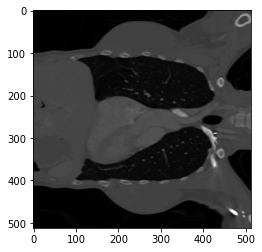

In [9]:
# Slice the volume and visualize
imgSlice = img[:,200,:] # Changge the index here to get different slices from the volume
#imgSlice = cv2.rotate(imgSlice, cv2.ROTATE_90_CLOCKWISE) # rotating slice back to original form
imgSlice = cv2.resize(imgSlice, dsize=(512, 512))
plt.imshow(imgSlice, cmap='gray')
plt.show()

We can also see how the label volume looks like.

In [109]:
# Load label volume
maskPath = os.path.join(trainInMasks, '1.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (512, 512, 197), numpy.memmap)

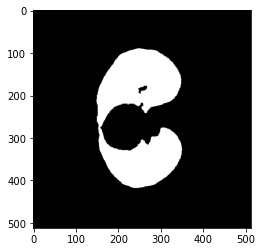

In [110]:
# Slice the mask volume and visualize
maskSlice = mask[:,:,100] # Change the index here to get different slices from the volume
#maskSlice = cv2.rotate(maskSlice, cv2.ROTATE_90_CLOCKWISE) # rotating slice back to original form
plt.imshow(maskSlice, cmap='gray')
plt.show()

The first thing we need to fix is hounsfield scale which is frequently used in CT scan. The hounsfield scale is boundeless which introduces a problem for us. We will fix this by using a normalization function.

# Preprocessing

## Normalization

In [60]:
def normalize_intensity(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN # Take all values below threshold and assign the min value
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE # normalzies between 0 and 1

In [61]:
n_img = normalize_intensity(img)
np.min(n_img), np.max(n_img), n_img.shape, type(n_img)

(0.018536585365853658, 1.0, (512, 512, 197), numpy.ndarray)

Now we have values between 0 and 1.

## Convert data to 2D slices

In [63]:
# Function for reading image volumes

def read_volume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalize_intensity(img)
    else:
        return img

In [67]:
read_volume(imgPath, normalize=True)

array([[[0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659],
        [0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659],
        [0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659],
        ...,
        [0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659],
        [0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659],
        [0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659]],

       [[0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659],
        [0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659],
        [0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659],
        ...,
        [0.01853659, 0.01853659, 0.01853659, ..., 0.01853659,
         0.01853659, 0.01853659],
        [0.0

In [69]:
read_volume(maskPath, normalize=False)

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [111]:
# Function for saving image slices
def save_slice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')

In [99]:
save_slice(n_img[:,:,100], 'test', trainOutDir)
save_slice(mask[:,:,100], 'test', trainOutMasks)

Lets use above function to save volume image as slices.

In [112]:
def vol_to_slice(vol, fname, path): # Function take image volume, name of output and path for storing the outputs
    (dimx, dimy, dimz) = vol.shape
    cnt = 0 # To keep track of total slices created
    
    # For sagittal
    if SLICE_X:
        cnt+= dimx
        print("Slicing X: ")
        for i in range(dimx): # We loop through all the slices in X-direction and save them as image files
            save_slice(vol[i,:,:], fname+f"-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x", path)
    
    # For coronal
    if SLICE_Y:
        cnt+= dimy
        print("Slicing Y: ")
        for i in range(dimy): # We loop through all the slices in Y-direction and save them as image files
            save_slice(vol[:,i,:], fname+f"-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y", path)
            
    # For axial
    if SLICE_Z:
        cnt+= dimz
        print("Slicing Z: ")
        for i in range(dimz): # We loop through all the slices in Z-direction and save them as image files
            save_slice(vol[:,:,i], fname+f"-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z", path)
            
    return cnt

Now we will loop over all the volumes in input path and save them as slices.

In [102]:
# For training images
for idx, filename in enumerate(sorted(glob.glob(trainInDir + '*.nii'))):
    img = read_volume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    num_slices = vol_to_slice(img, 'data'+str(idx), trainOutDir)
    print(f'\n{filename}, {num_slices} slice created \n')

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\1.nii (512, 512, 197) 1221 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data0-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data0-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data0-slice196_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\1.nii, 1221 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\10.nii (512, 512, 148) 1172 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data1-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data1-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data1-slice147_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\10.ni

Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data16-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data16-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data16-slice100_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\113.nii, 1125 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\114.nii (512, 512, 101) 1125 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data17-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data17-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data17-slice100_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\114.nii, 1125 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\115.nii (512, 512, 185) 1209 0.0185365853658536

Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data32-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data32-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data32-slice164_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\128.nii, 1189 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\129.nii (512, 512, 170) 1194 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data33-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data33-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data33-slice169_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\129.nii, 1194 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\13.nii (512, 512, 154) 1178 0.

Slicing Z: 


[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data48-slice158_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\142.nii, 1183 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\143.nii (512, 512, 100) 1124 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data49-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data49-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data49-slice099_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\143.nii, 1124 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\144.nii (512, 512, 100) 1124 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data50-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data50-slice511_y.pn

[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data64-slice150_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\21.nii, 1175 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\22.nii (512, 512, 151) 1175 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data65-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data65-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data65-slice150_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\22.nii, 1175 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\23.nii (512, 512, 151) 1175 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data66-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\tra

Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data96-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data96-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data96-slice174_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\50.nii, 1199 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\51.nii (512, 512, 159) 1183 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data97-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data97-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data97-slice158_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\51.nii, 1183 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\52.nii (512, 512, 159) 1183 0.018

Slicing Z: 


[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data112-slice171_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\65.nii, 1196 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\66.nii (512, 512, 172) 1196 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data113-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data113-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data113-slice171_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\66.nii, 1196 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\67.nii (512, 512, 87) 1111 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data114-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/dat

[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data128-slice164_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\8.nii, 1189 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\80.nii (512, 512, 159) 1183 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data129-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data129-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data129-slice158_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\80.nii, 1183 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\volumes\81.nii (512, 512, 106) 1130 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/data130-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\slices/dat

In [104]:
# For validation images
for idx, filename in enumerate(sorted(glob.glob(valInDir + '*.nii'))):
    img = read_volume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    num_slices = vol_to_slice(img, 'data'+str(idx), valOutDir)
    print(f'\n{filename}, {num_slices} slice created \n')

E:/skia_projects/ct_segmentation_3d/data_nifti\valid\volumes\1.nii (512, 512, 189) 1213 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data0-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data0-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data0-slice188_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\valid\volumes\1.nii, 1213 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\valid\volumes\10.nii (512, 512, 183) 1207 0.018536585365853658 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data1-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data1-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data1-slice182_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\valid\volumes\10.ni

[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data16-slice165_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\valid\volumes\6.nii, 1190 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\valid\volumes\7.nii (512, 512, 102) 1126 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data17-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data17-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data17-slice101_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\valid\volumes\7.nii, 1126 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\valid\volumes\8.nii (512, 512, 102) 1126 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data18-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\slices/data18-slice511_y.png
[+] Sl

In [113]:
# For training masks
for idx, filename in enumerate(sorted(glob.glob(trainInMasks + '*.nii'))):
    img = read_volume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    num_slices = vol_to_slice(img, 'data'+str(idx), trainOutMasks)
    print(f'\n{filename}, {num_slices} slice created \n')

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\1.nii (512, 512, 197) 1221 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data0-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data0-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data0-slice196_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\1.nii, 1221 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\10.nii (512, 512, 148) 1172 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data1-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data1-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data1-slice147_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\10.nii, 1172 slice created 



E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\118.nii (512, 512, 98) 1122 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data21-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data21-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data21-slice097_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\118.nii, 1122 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\119.nii (512, 512, 183) 1207 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data22-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data22-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data22-slice182_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\119.nii, 1207 slice

[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data38-slice164_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\133.nii, 1189 slice created 



E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\134.nii (512, 512, 165) 1189 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data39-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data39-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data39-slice164_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\134.nii, 1189 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\135.nii (512, 512, 186) 1210 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data40-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data40-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data40-slice185_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\135.nii, 1210 slic

[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data56-slice161_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\15.nii, 1186 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\150.nii (512, 512, 179) 1203 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data57-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data57-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data57-slice178_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\150.nii, 1203 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\16.nii (512, 512, 162) 1186 0.0 2.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data58-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data58-slice

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\3.nii (512, 512, 197) 1221 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data73-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data73-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data73-slice196_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\3.nii, 1221 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\30.nii (512, 512, 167) 1191 0.0 2.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data74-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data74-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data74-slice166_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\30.nii, 1191 slice crea

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\47.nii (512, 512, 195) 1219 0.0 2.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data92-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data92-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data92-slice194_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\47.nii, 1219 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\48.nii (512, 512, 195) 1219 0.0 2.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data93-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data93-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data93-slice194_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\48.nii, 1219 slice cr

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\62.nii (512, 512, 97) 1121 0.0 2.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data109-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data109-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data109-slice096_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\62.nii, 1121 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\63.nii (512, 512, 151) 1175 0.0 2.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data110-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data110-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data110-slice150_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\63.nii, 1175 sli

[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data128-slice164_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\8.nii, 1189 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\80.nii (512, 512, 159) 1183 0.0 2.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data129-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data129-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data129-slice158_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\80.nii, 1183 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\train\masks\81.nii (512, 512, 106) 1130 0.0 2.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data130-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\train\masks/img/data130-sl

In [114]:
# For validation masks
for idx, filename in enumerate(sorted(glob.glob(valInMasks + '*.nii'))):
    img = read_volume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    num_slices = vol_to_slice(img, 'data'+str(idx), valOutMasks)
    print(f'\n{filename}, {num_slices} slice created \n')

E:/skia_projects/ct_segmentation_3d/data_nifti\valid\masks\1.nii (512, 512, 189) 1213 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data0-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data0-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data0-slice188_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\valid\masks\1.nii, 1213 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\valid\masks\10.nii (512, 512, 183) 1207 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data1-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data1-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data1-slice182_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\valid\masks\10.nii, 1207 slice created 



E:/skia_projects/ct_segmentation_3d/data_nifti\valid\masks\8.nii (512, 512, 102) 1126 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data18-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data18-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data18-slice101_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\valid\masks\8.nii, 1126 slice created 

E:/skia_projects/ct_segmentation_3d/data_nifti\valid\masks\9.nii (512, 512, 183) 1207 0.0 1.0
Slicing X: 
Slicing Y: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data19-slice511_x.png
Slicing Z: aved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data19-slice511_y.png
[+] Slice saved: E:/skia_projects/ct_segmentation_3d/data_slices\valid\masks/img/data19-slice182_z.png
E:/skia_projects/ct_segmentation_3d/data_nifti\valid\masks\9.nii, 1207 slice create